In [1]:
!pip install SentencePiece 

In [1]:
import transformers 
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns


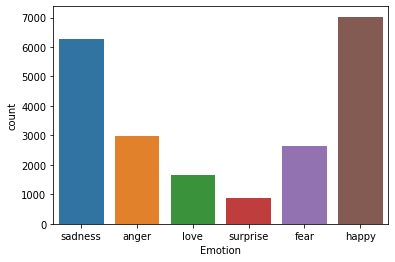

In [2]:
df = pd.read_csv("Emotion_final.csv")
sns.countplot(df.Emotion)

In [3]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Emotion"] = label_encoder.fit_transform(df["Emotion"])
print(df)

                                                    Text  Emotion
0                                i didnt feel humiliated        4
1      i can go from feeling so hopeless to so damned...        4
2       im grabbing a minute to post i feel greedy wrong        0
3      i am ever feeling nostalgic about the fireplac...        3
4                                   i am feeling grouchy        0
...                                                  ...      ...
21454               Melissa stared at her friend in dism        1
21455  Successive state elections have seen the gover...        1
21456               Vincent was irritated but not dismay        1
21457  Kendall-Hume turned back to face the dismayed ...        1
21458                    I am dismayed , but not surpris        1

[21459 rows x 2 columns]


#### labels

0:anger
1:fear
2:happy
3:love
4:sadness
5:surprise

In [4]:
for i in range(100):
    df = df.sample(frac = 1)
    df = df.sample(frac = 1)
    df = df.sample(frac = 1)
    df = df.sample(frac = 1)
    df = df.sample(frac = 1)
print(df)

                                                    Text  Emotion
6899   i feel very blessed with how easy this has bee...        2
16196  i wrote two years ago so many things i feel un...        1
16855  i have faith in supreme power and i accept eve...        4
14044   i believe and some i feel sadly are not truthful        2
942            i wake up and i feel absolutely worthless        4
...                                                  ...      ...
13104  i don t feel like i m welcomed at home even th...        2
14444                       i feel so useless and stupid        4
17780  when i learnt that my best friend had failed t...        0
17934  i dont really care and i dont feel proud of my...        2
9524         i feel honored to have that kind of support        2

[21459 rows x 2 columns]


In [5]:
print("SHAPE::",df.shape)

SHAPE:: (21459, 2)


In [6]:
class_name = ['sadness','anger','love','surprise','fear','happy']

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cpu')

In [9]:
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'

In [10]:
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [11]:
bert_model = XLNetModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|██████████████████████████████████████████████████████████████████████████| 21459/21459 [00:07<00:00, 2836.57it/s]


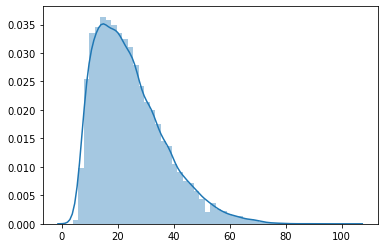

In [12]:
from tqdm import tqdm
token_lens = []
for txt in tqdm(df.Text):
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
sns.distplot(token_lens)

In [13]:
from torch.utils.data import Dataset, DataLoader
class TextDataset(Dataset):
    def __init__(self,texts,targets,tokenizer,max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self,item):
        text = str(self.texts[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            )
        
        return {
            'text_text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

In [14]:
size=len(df)
df_test = df[0:int(size/8)]
df_val = df[int(size/8):int(size/4)]
df_train = df[int(size/4):size]

In [15]:
df_train.shape, df_val.shape, df_test.shape


((16095, 2), (2682, 2), (2682, 2))

In [16]:
print(df)

                                                    Text  Emotion
6899   i feel very blessed with how easy this has bee...        2
16196  i wrote two years ago so many things i feel un...        1
16855  i have faith in supreme power and i accept eve...        4
14044   i believe and some i feel sadly are not truthful        2
942            i wake up and i feel absolutely worthless        4
...                                                  ...      ...
13104  i don t feel like i m welcomed at home even th...        2
14444                       i feel so useless and stupid        4
17780  when i learnt that my best friend had failed t...        0
17934  i dont really care and i dont feel proud of my...        2
9524         i feel honored to have that kind of support        2

[21459 rows x 2 columns]


In [17]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df_train.Emotion.values),
                                                 df_train.Emotion.values)

In [18]:
class_weights

array([1.19063471, 1.32928642, 0.51017497, 2.18979592, 0.57293891,
       4.07056146])

In [19]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = TextDataset(
        texts = df.Text.to_numpy(), 
        targets = df.Emotion.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=0)

In [20]:
MAX_LEN=10
BATCH_SIZE = 5
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [21]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = XLNetModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.4)
        #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
        self.drop1 = nn.Dropout(p=0.4)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, n_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        output= pooled_output[0][:,0]
        output = self.drop(output)
        output = self.out1(output)
        output = self.relu(output)
        output = self.drop1(output)
        return self.out(output)

In [22]:
model = SentimentClassifier(len(class_name))
model = model.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
#class_weights = torch.FloatTensor(class_weights).to(device)
#weight=class_weights
loss_fn = nn.CrossEntropyLoss().to(device)

C:\Users\Fatemeh\anaconda3\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [24]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    print(data_loader)
    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
      model = model.eval()
      losses = []
      correct_predictions = 0
      with torch.no_grad():
        for d in data_loader:
          input_ids = d["input_ids"].to(device)
          attention_mask = d["attention_mask"].to(device)
          targets = d["targets"].to(device)
          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)
          loss = loss_fn(outputs, targets)
          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())
      return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------


C:\Users\Fatemeh\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss 1.6280935624994526 accuracy 0.3147561354457906
Val   loss 1.5852826500738133 accuracy 0.3340790454884415

Epoch 2/5
----------
Train loss 1.6115930628132176 accuracy 0.31264367816091954
Val   loss 1.5856635301916737 accuracy 0.3340790454884415

Epoch 3/5
----------
Train loss 1.605031965681765 accuracy 0.32078285181733457
Val   loss 1.5780253032954268 accuracy 0.3351976137211036

Epoch 4/5
----------
Train loss 1.5248996298870117 accuracy 0.40186393289841565
Val   loss 1.5920437968004792 accuracy 0.5123042505592841

Epoch 5/5
----------
Train loss 1.3269283382483024 accuracy 0.5278657968313141
Val   loss 1.3574458873367676 accuracy 0.546607009694258



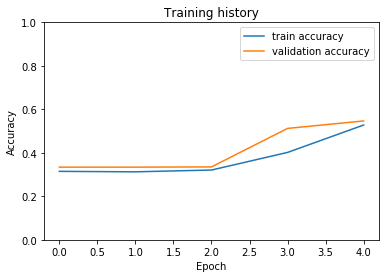

In [27]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [28]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

C:\Users\Fatemeh\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.5555555555555556

In [30]:
def get_predictions(model, data_loader):
    model = model.eval()
    text_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["text_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
            _, preds = torch.max(outputs, dim=1)
            text_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return text_texts, predictions, prediction_probs, real_values

In [31]:
y_text_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [32]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

     sadness       0.64      0.32      0.43       374
       anger       0.63      0.40      0.49       321
        love       0.49      0.90      0.64       875
    surprise       0.00      0.00      0.00       203
        fear       0.65      0.56      0.60       804
       happy       0.00      0.00      0.00       105

    accuracy                           0.56      2682
   macro avg       0.40      0.36      0.36      2682
weighted avg       0.52      0.56      0.51      2682



C:\Users\Fatemeh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
class_names = ['anger','fear','happy','love','sadness','surprise']

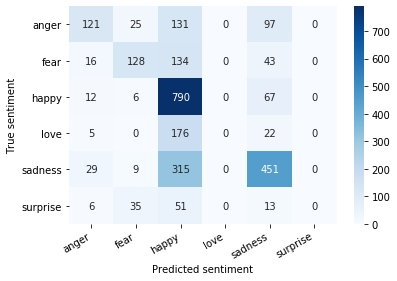

In [43]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

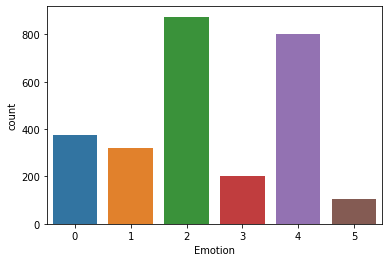

In [44]:
sns.countplot(df_test.Emotion)

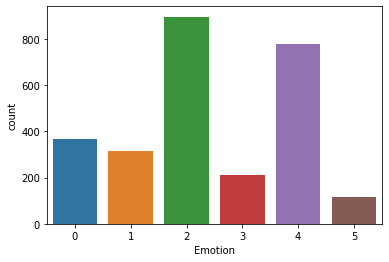

In [45]:
sns.countplot(df_val.Emotion)

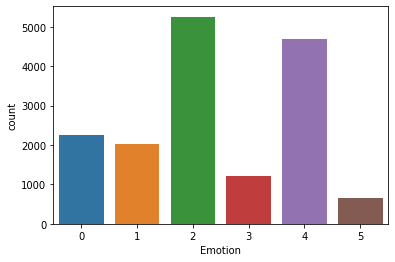

In [46]:
sns.countplot(df_train.Emotion)